In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('Admission_Predict.csv')

In [3]:
data.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

# Exploratory Data Analysis

In [4]:
data.drop('Serial No.', axis=1, inplace=True)
data.columns=[cl.strip() for cl in data.columns]

In [5]:
data.head()

GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  Research  \
0        337          118                  4  4.5  4.5  9.65         1   
1        324          107                  4  4.0  4.5  8.87         1   
2        316          104                  3  3.0  3.5  8.00         1   
3        322          110                  3  3.5  2.5  8.67         1   
4        314          103                  2  2.0  3.0  8.21         0   

   Chance of Admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65

In [6]:
ProfileReport(data)

In [7]:
data.groupby('University Rating').mean()

GRE Score  TOEFL Score       SOP       LOR      CGPA  \
University Rating                                                          
1                  303.153846    99.076923  1.884615  2.211538  7.745769   
2                  309.177570   103.523364  2.705607  2.925234  8.183738   
3                  315.954887   106.887218  3.364662  3.402256  8.552256   
4                  324.824324   111.824324  4.108108  4.006757  9.021622   
5                  328.333333   113.666667  4.500000  4.358333  9.291167   

                   Research  Chance of Admit  
University Rating                             
1                  0.192308         0.548077  
2                  0.299065         0.625981  
3                  0.533835         0.711880  
4                  0.797297         0.818108  
5                  0.866667         0.888167

# Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
X = data.drop('Chance of Admit', axis=1).to_numpy()
y = data['Chance of Admit'].to_numpy().reshape(-1,1)

In [10]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
# R2 score
print(f'R2: {model.score(X_test, y_test)}')

# MSE
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2: 0.7248631204868361
MSE: 0.23668353998188574


The success of a linear regression model also depends on some fundamental assumptions about the nature of the underlying data that it tries to model. It is, therefore, extremely important to check the quality of the linear regression model, by verifying whether these assumptions were “reasonably” satisfied.

Assumptions:

1. **Linearity**: The expected value of the dependent variable is a linear function of each independent variable, holding the others fixed.
4. **Normality**: The errors are generated from a Normal distribution (of unknown mean and variance, which can be estimated from the data). Note, this is not a necessary condition to perform linear regression unlike the top three above. However, without this assumption being satisfied, you cannot calculate the so-called ‘confidence’ or ‘prediction’ intervals easily as the well-known analytical expressions corresponding to Gaussian distribution cannot be used.
2. **Independence**: The errors (residuals of the fitted model) are independent of each other.
3. **Homoscedasticity (constant variance)**: The variance of the errors is constant with respect to the predicting variables or the response.

For multiple linear regression, judging multicollinearity is also critical from the statistical inference point of view. This assumption assumes minimal or no linear dependence between the predicting variables.

**What can be done?**

The proxy of true errors are the residuals, which are just the difference between the observed values and the fitted values.

Bottom line — we need to plot the residuals, check their random nature, variance, and distribution for evaluating the model quality. This is the visual analytics needed for goodness-of-fit estimation of a linear model.

Apart from this, multicollinearity can be checked from the correlation matrix and heatmap, and outliers in the data (residual) can be checked by so-called Cook’s distance plots.

### Linearity

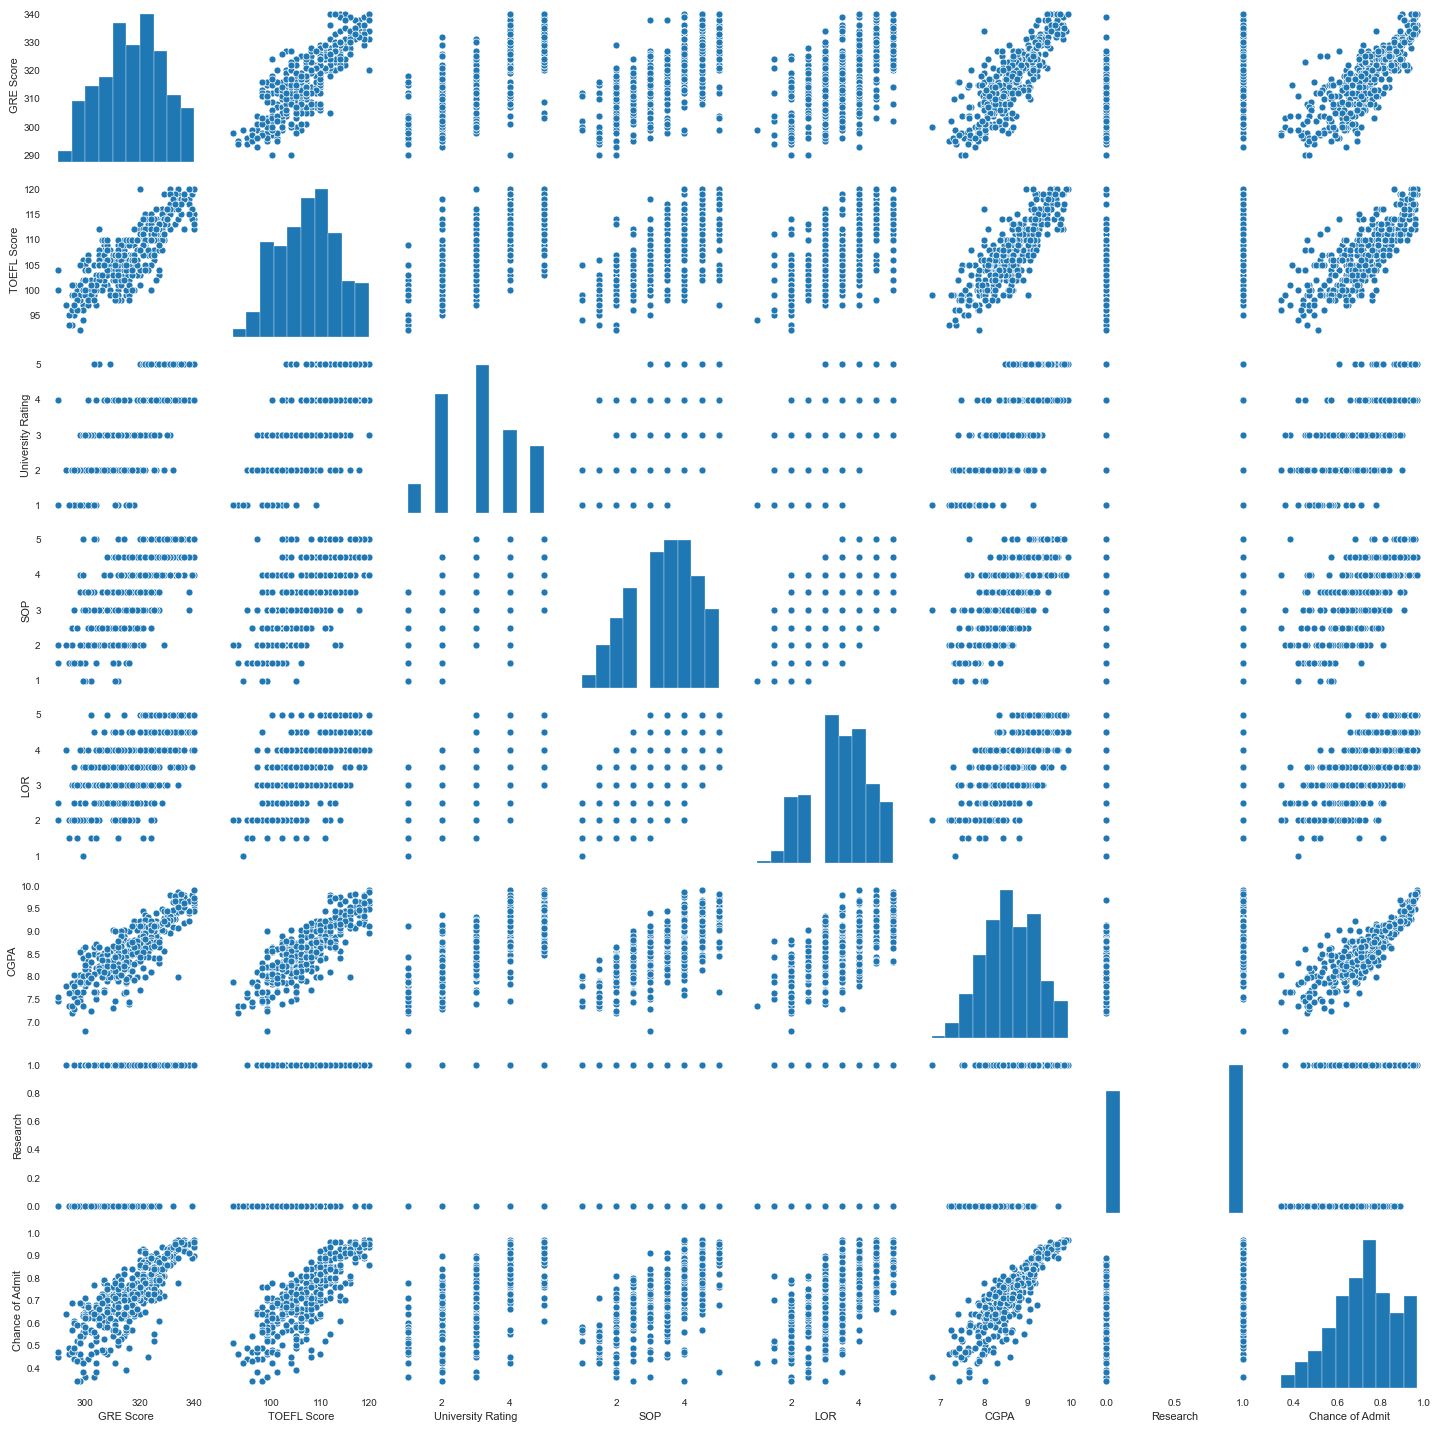

In [14]:
# linearity
sns.pairplot(data)

### Multicollinearity

This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

**Why it can happen:** A lot of data is just naturally correlated. For example, if trying to predict a house price with square footage, the number of bedrooms, and the number of bathrooms, we can expect to see correlation between those three variables because bedrooms and bathrooms make up a portion of square footage.

**What it will affect:** Multicollinearity causes issues with the interpretation of the coefficients. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

**How to detect it:** There are a few ways, but we will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF).

**How to fix it:** This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

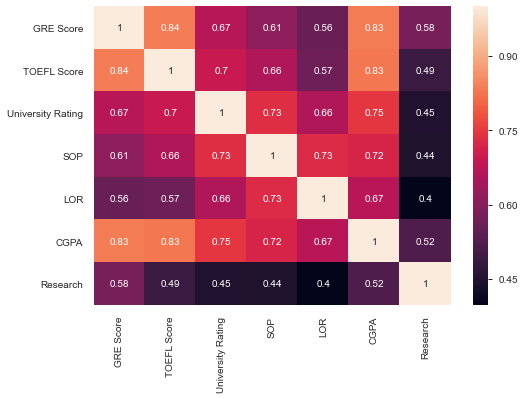

In [15]:
sns.heatmap(data.drop('Chance of Admit', axis=1).corr(), annot=True)

In [16]:
formula_str = data.columns[-1]+' ~ ' + ' + '.join(data.columns[:-1])
formula_str

'Chance of Admit ~ GRE Score + TOEFL Score + University Rating + SOP + LOR + CGPA + Research'

In [17]:
import statsmodels.api as sm
# import statsmodel.formula.api as sm

OLS_model = sm.OLS(y_train, X_train, hasconst=True)
results = OLS_model.fit()
print(results.summary())

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     228.4
Date:                Sat, 18 Jul 2020   Prob (F-statistic):          2.48e-107
Time:                        11:47:27   Log-Likelihood:                -171.95
No. Observations:                 300   AIC:                             357.9
Df Residuals:                     293   BIC:                             383.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1549      0.054      2.878      0.0

**The condition number is low enough (< 10) -- high might indicate that there are
strong multicollinearity or other numerical problems.**

In [18]:
# Examine the variance inflation factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

for i in range(len(data.columns[:-1])):
    v=vif(X_train,i)
    print(f"Variance inflation factor for {data.columns[i]}: {round(v,2)}")

Variance inflation factor for GRE Score: 4.9
Variance inflation factor for TOEFL Score: 4.41
Variance inflation factor for University Rating: 3.27
Variance inflation factor for SOP: 3.21
Variance inflation factor for LOR: 2.59
Variance inflation factor for CGPA: 6.0
Variance inflation factor for Research: 1.53


Using a cutoff of > 10, we can keep all regressors.

### Normality of Error Terms

**Why it can happen**: This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.

**What it will affect:** A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

**How to detect it**: There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test or Shapiro-Wilk for normality. We will also plot the histogram and the Q-Q plot of the normalized residuals.

**How to fix it:** It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.


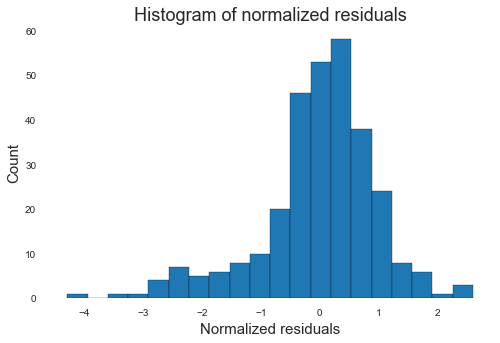

In [19]:
# histogram of the residuals
plt.figure(figsize=(8,5))
plt.hist(results.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

<Figure size 576x360 with 0 Axes>

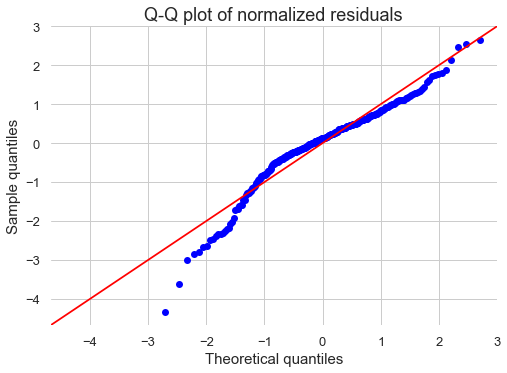

In [20]:
# Q-Q plot of the residuals
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(results.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

We can see that the residuals do not look like they are normally distributed. From the Shapiro-Wilk test performed below, this is also demonstrated. We have sufficient evidence to reject that the residuals come from a normally distributed population.

In [21]:
from scipy.stats import shapiro

shapiro(results.resid).pvalue

1.3278342869682547e-09

Keep in mind:

1. Not remove outliers just because they make the distribution of the residuals non-normal but examine the case that has that high residual and see if there are problems with it (the easiest would be if it is a data entry error) but you must justify your deletion on substantive grounds.
2. Assuming there is no good reason to remove that observation, you can run the regression with and without it and see if there are any large differences in the parameter estimates; if not, you can leave it in and note that removing it made little difference
3. If it makes a big difference, then you could try robust regression (minimizes absolute difference instead of squared which will be more robust to outliers), which deals with outliers or quantile regression, which makes no assumptions about the distribution of the residuals.

In [22]:
robust_model = HuberRegressor()
robust_model.fit(X_train, y_train)
robust_model.score(X_test, y_test)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7282953279059785

### Autocorrelation

This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

**Why it can happen:** In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.

**What it will affect:** This will impact our model estimates.

**How to detect it:** We could perform a Durbin-Watson test to determine if either positive or negative correlation is present. Alternatively, you could create plots of residual autocorrelations.

**How to fix it:** A simple fix of adding lag variables can fix this problem. Alternatively, interaction terms, additional variables, or additional transformations may fix this.

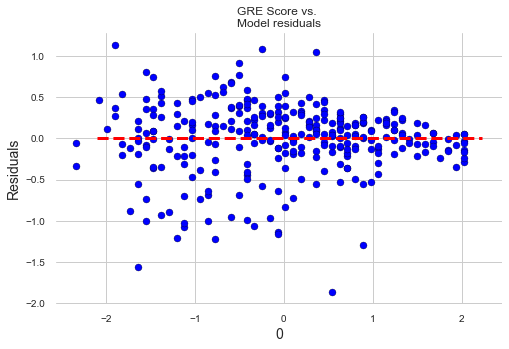

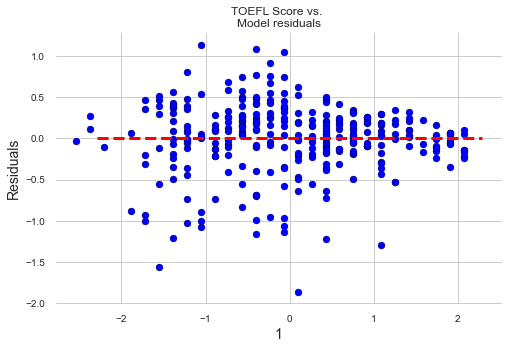

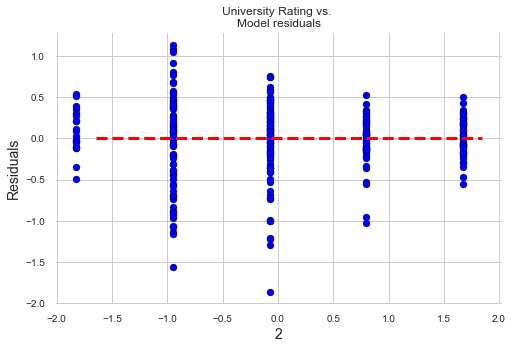

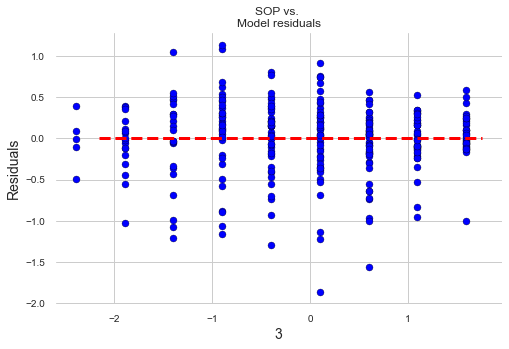

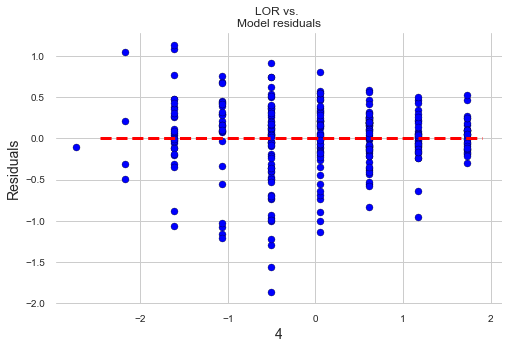

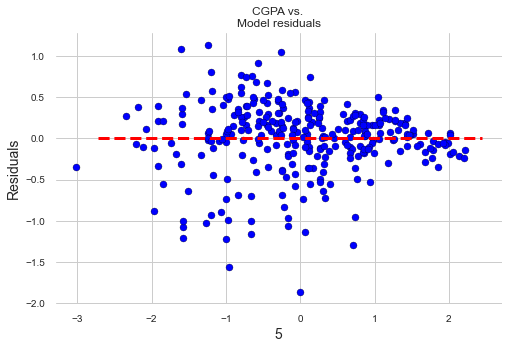

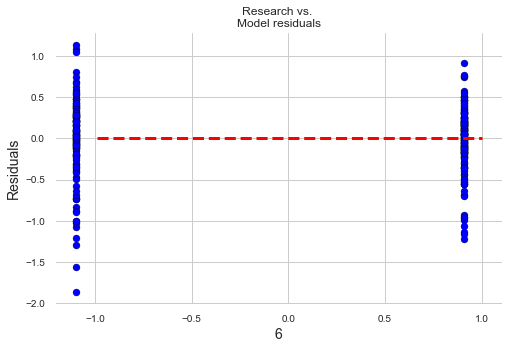

In [23]:
for c in range(len(data.columns[:-1])):
    plt.figure(figsize=(8,5))
    plt.title(f"{data.columns[c]} vs. \nModel residuals")
    plt.scatter(x=X_train[:,c],y=results.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(X_train[:,c])
    xmax = max(X_train[:,c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()


### Homoscedasticity

This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

**Why it can happen:** Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.

**What it will affect:** Significance tests for coefficients due to the standard errors being biased. Additionally, the confidence intervals will be either too wide or too narrow.

**How to detect it:** Plot the residuals and see if the variance appears to be uniform.

**How to fix it:** Heteroscedasticity can be solved either by using weighted least squares regression instead of the standard OLS or transforming either the dependent or highly skewed variables. Performing a log, sqrt, or cube transformation on the dependent variable is not a bad place to start.

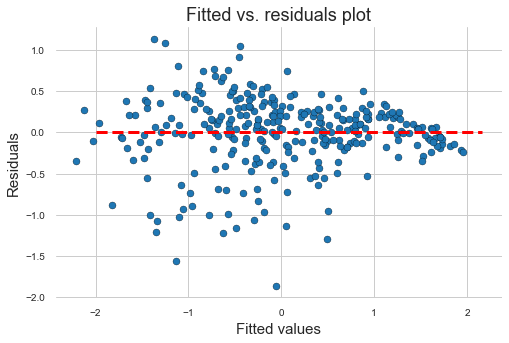

In [24]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=results.fittedvalues,y=results.resid,edgecolor='k')
xmin=min(results.fittedvalues)
xmax = max(results.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

# Neural Net

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [26]:
def build_model():
    model = keras.Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    
    optimizer = RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [27]:
nn_model = build_model()
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [28]:
EPOCHS = 1000

history = nn_model.fit(
  X_train, y_train, validation_split = 0.2,
  epochs=EPOCHS, verbose=0, callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:0.3719,  mae:0.4905,  mse:0.3719,  val_loss:0.2331,  val_mae:0.3364,  val_mse:0.2331,  
....................................................................................................
Epoch: 100, loss:0.1369,  mae:0.2746,  mse:0.1369,  val_loss:0.1838,  val_mae:0.2917,  val_mse:0.1838,  
....................................................................................................
Epoch: 200, loss:0.1124,  mae:0.2594,  mse:0.1124,  val_loss:0.2068,  val_mae:0.3134,  val_mse:0.2068,  
....................................................................................................
Epoch: 300, loss:0.0942,  mae:0.2364,  mse:0.0942,  val_loss:0.2238,  val_mae:0.3353,  val_mse:0.2238,  
....................................................................................................
Epoch: 400, loss:0.0860,  mae:0.2212,  mse:0.0860,  val_loss:0.2286,  val_mae:0.3504,  val_mse:0.2286,  
........................................................................

In [29]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

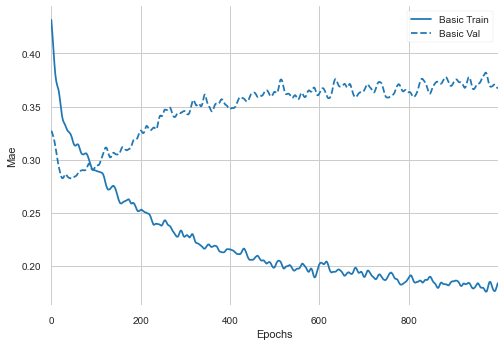

In [30]:
plotter.plot({'Basic': history}, metric = "mae")

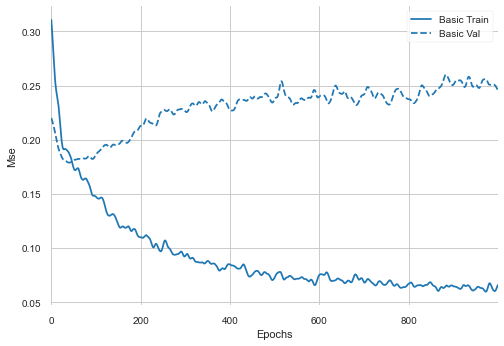

In [31]:
plotter.plot({'Basic': history}, metric = "mse")

In [32]:
nn_model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = nn_model.fit(X_train, y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.4826,  mae:0.5206,  mse:0.4826,  val_loss:0.2576,  val_mae:0.3782,  val_mse:0.2576,  
................................................

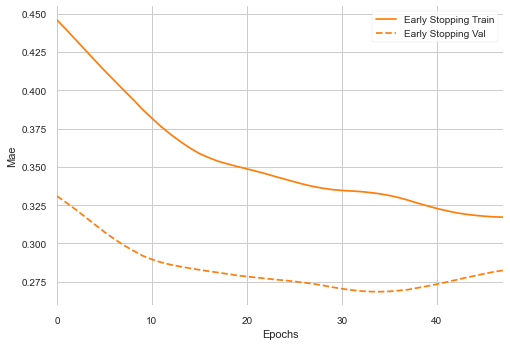

In [33]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")

In [34]:
loss, mae, mse = nn_model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Sqr Error: {:5.2f}".format(mse))

100/100 - 0s - loss: 0.2462 - mae: 0.3467 - mse: 0.2462
Testing set Mean Abs Error:  0.35
Testing set Mean Sqr Error:  0.25


Text(0, 0.5, 'Count')

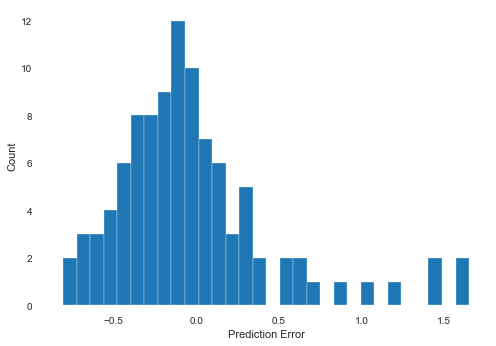

In [35]:
# Let's take a look at the error distribution
y_pred = model.predict(X_test).flatten()
error = y_pred - y_test.flatten()
plt.hist(error, bins = 30)
plt.xlabel("Prediction Error")
plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small

# Decision Tree and Random Forest

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [37]:
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.620238144625196

In [38]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6423764695052252

In [39]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print(f'Decision Tree MSE: {mean_squared_error(y_test, y_pred_dt)}')
print(f'Random Forest MSE: {mean_squared_error(y_test, y_pred_rf)}')

Decision Tree MSE: 0.3266860496464163
Random Forest MSE: 0.3076417938885339
